<a href="https://colab.research.google.com/github/chirag2saraiya/TSAI-DeepVision-EVA4/blob/master/06-Generative-Adversarial-Networks-(GAN)/Copy_of_Copy_of_DCGAN_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/My\ Drive/Copy\ of\ cars_data.zip .

In [ ]:
!unzip -q "/content/cars_data.zip"

In [ ]:
folder = "/content/cars_data"

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
import numpy as np
import datetime
import os, sys

In [ ]:
import glob
from PIL import Image
from matplotlib.pyplot import imshow, imsave
%matplotlib inline
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
folder = "/content/cars_data"

In [ ]:
!rm /content/cars_data/.DS_Store

In [ ]:
for filename in os.listdir(folder):
    img = Image.open(os.path.join(folder,filename)).convert('RGB')
    img.save(os.path.join(folder,filename)) 
    

In [ ]:
IMAGE_DIM = (96, 96, 3)

In [ ]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(10, n_noise).to(DEVICE)
    y_hat = G(z).view(10, 3, 96, 96).permute(0, 2, 3, 1) # (100, 28, 28)
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result

In [ ]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 100 -> 50
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 50 -> 25
            nn.Conv2d(512, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 25 -> 13
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 13 -> 7
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
        )        
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [ ]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, out_channel=1, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        assert IMAGE_DIM[0] % 2**5 == 0, 'Should be divided 32' # we want to generate our image in 5 steps as in Descriminator
        self.init_dim = (IMAGE_DIM[0] // 2**5, IMAGE_DIM[1] // 2**5)
        self.fc = nn.Sequential(
            nn.Linear(input_size, self.init_dim[0]*self.init_dim[1]*512),    # 1*100 -> 3*3*512
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, bias=False),                  # 512
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1, bias=False),  # 512x6x6
            nn.BatchNorm2d(512),
            nn.ReLU(),            
            # x2
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),   # 256x12x12
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),   # 128x24x24
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1, bias=False),   # 128x48x48
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, out_channel, 4, stride=2, padding=1, bias=False), # 3x96x96
            nn.Tanh(),
        )
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, self.init_dim[0], self.init_dim[1])
        y_ = self.conv(y_)
        return y_

In [ ]:
class CARS(Dataset):
    '''
    CARS Dataset
    You should download this dataset from below url.
    url: https://ai.stanford.edu/~jkrause/cars/car_dataset.html
    '''
    def __init__(self, data_path, transform=None):
        '''
        Args:
            data_path (str): path to dataset
        '''
        self.data_path = data_path
        self.transform = transform
        self.fpaths = sorted(glob.glob(os.path.join(data_path, '*.png')))
        #gray_lst = [266, 1085, 2176, 3048, 3439, 3469, 3539, 4577, 4848, 5177, 5502, 5713, 6947, 7383, 7693, 7774, 8137, 8144]
        #for num in gray_lst:
        #    self.fpaths.remove(os.path.join(data_path, '{:05d}.png'.format(num)))
        
    def __getitem__(self, idx):
        img = self.transform(Image.open(self.fpaths[idx]))
        return img

    def __len__(self):
        return len(self.fpaths)

In [ ]:
from torchsummary import summary
IMAGE_DIM = (96, 96, 3)
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
summary(D, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 48, 48]          13,824
       BatchNorm2d-2          [-1, 512, 48, 48]           1,024
         LeakyReLU-3          [-1, 512, 48, 48]               0
            Conv2d-4          [-1, 512, 24, 24]       2,359,296
       BatchNorm2d-5          [-1, 512, 24, 24]           1,024
         LeakyReLU-6          [-1, 512, 24, 24]               0
            Conv2d-7          [-1, 256, 12, 12]       1,179,648
       BatchNorm2d-8          [-1, 256, 12, 12]             512
         LeakyReLU-9          [-1, 256, 12, 12]               0
           Conv2d-10            [-1, 128, 6, 6]         294,912
      BatchNorm2d-11            [-1, 128, 6, 6]             256
        LeakyReLU-12            [-1, 128, 6, 6]               0
           Conv2d-13            [-1, 128, 3, 3]         147,456
      BatchNorm2d-14            [-1, 12

In [ ]:
from torchsummary import summary
IMAGE_DIM = (96, 96, 3)
G = Generator(out_channel=IMAGE_DIM[-1]).to(DEVICE)
summary(G, input_size=(1, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4608]         465,408
              ReLU-2                 [-1, 4608]               0
            Conv2d-3            [-1, 512, 3, 3]       2,359,296
       BatchNorm2d-4            [-1, 512, 3, 3]           1,024
              ReLU-5            [-1, 512, 3, 3]               0
   ConvTranspose2d-6            [-1, 512, 6, 6]       4,194,304
       BatchNorm2d-7            [-1, 512, 6, 6]           1,024
              ReLU-8            [-1, 512, 6, 6]               0
   ConvTranspose2d-9          [-1, 256, 12, 12]       2,097,152
      BatchNorm2d-10          [-1, 256, 12, 12]             512
             ReLU-11          [-1, 256, 12, 12]               0
  ConvTranspose2d-12          [-1, 128, 24, 24]         524,288
      BatchNorm2d-13          [-1, 128, 24, 24]             256
             ReLU-14          [-1, 128,

In [ ]:

transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)

In [ ]:
dataset = CARS(data_path='/content/cars_data/', transform=transform)

In [ ]:
len(dataset)

612

In [ ]:
batch_size = 64

In [ ]:
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
max_epoch = 2200
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [ ]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [ ]:
!mkdir samples

In [ ]:
from tqdm import tqdm
for epoch in range(max_epoch):
    for idx, images in enumerate(tqdm(data_loader)):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{:05d}.jpg'.format(MODEL_NAME, step), img[0])
            G.train()
        step += 1
    print('Epoch: {}/{}, D Loss: {:.4f}, G Loss: {:.4f}, Time:{}'.format(epoch, max_epoch, D_loss.item(), G_loss.item(), dt))

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 0/2200, D Loss: 1.1470, G Loss: 0.8847, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1/2200, D Loss: 1.0575, G Loss: 0.9535, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 2/2200, D Loss: 0.9568, G Loss: 1.0389, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 3/2200, D Loss: 0.7220, G Loss: 1.2660, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 4/2200, D Loss: 0.5372, G Loss: 1.4704, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 5/2200, D Loss: 0.8980, G Loss: 1.1427, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 6/2200, D Loss: 0.5024, G Loss: 1.6736, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 7/2200, D Loss: 0.5416, G Loss: 1.5900, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 8/2200, D Loss: 0.3762, G Loss: 1.8120, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 9/2200, D Loss: 0.3097, G Loss: 1.9598, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 10/2200, D Loss: 0.2787, G Loss: 2.0797, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 11/2200, D Loss: 0.2441, G Loss: 2.0850, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 12/2200, D Loss: 0.3356, G Loss: 1.9157, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 13/2200, D Loss: 0.4061, G Loss: 2.3624, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 14/2200, D Loss: 0.2397, G Loss: 2.3042, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 15/2200, D Loss: 0.7719, G Loss: 1.6424, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 16/2200, D Loss: 0.3389, G Loss: 2.1807, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 17/2200, D Loss: 0.3257, G Loss: 2.6010, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 18/2200, D Loss: 0.2567, G Loss: 2.5475, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 19/2200, D Loss: 0.1471, G Loss: 2.8841, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 20/2200, D Loss: 0.1367, G Loss: 2.9979, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 21/2200, D Loss: 0.3652, G Loss: 2.7243, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 22/2200, D Loss: 1.1201, G Loss: 1.8681, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 23/2200, D Loss: 1.1839, G Loss: 0.9322, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 24/2200, D Loss: 0.5565, G Loss: 2.3997, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 25/2200, D Loss: 1.0331, G Loss: 1.2657, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 26/2200, D Loss: 0.8929, G Loss: 1.4593, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 27/2200, D Loss: 1.0697, G Loss: 1.5807, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 28/2200, D Loss: 0.8329, G Loss: 1.4754, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 29/2200, D Loss: 0.9392, G Loss: 1.6180, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 30/2200, D Loss: 0.9586, G Loss: 1.6679, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 31/2200, D Loss: 1.0469, G Loss: 1.2508, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 32/2200, D Loss: 0.6320, G Loss: 2.8142, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 33/2200, D Loss: 0.6081, G Loss: 1.5651, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 34/2200, D Loss: 0.9580, G Loss: 1.1279, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 35/2200, D Loss: 0.6721, G Loss: 2.2441, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 36/2200, D Loss: 0.6287, G Loss: 1.4271, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 37/2200, D Loss: 0.8345, G Loss: 1.5696, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 38/2200, D Loss: 0.6214, G Loss: 1.2890, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 39/2200, D Loss: 0.8906, G Loss: 1.7279, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 40/2200, D Loss: 0.1945, G Loss: 2.8228, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 41/2200, D Loss: 0.3969, G Loss: 2.4303, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 42/2200, D Loss: 0.8618, G Loss: 1.4833, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 43/2200, D Loss: 1.1270, G Loss: 0.9011, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 44/2200, D Loss: 1.0456, G Loss: 1.2524, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 45/2200, D Loss: 0.9600, G Loss: 2.0110, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 46/2200, D Loss: 0.9835, G Loss: 2.1586, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 47/2200, D Loss: 0.7345, G Loss: 1.9945, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 48/2200, D Loss: 0.7745, G Loss: 1.5812, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 49/2200, D Loss: 0.5519, G Loss: 1.9961, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 50/2200, D Loss: 1.2370, G Loss: 1.6195, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 51/2200, D Loss: 0.6001, G Loss: 2.1036, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 52/2200, D Loss: 0.9450, G Loss: 1.9506, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 53/2200, D Loss: 0.4427, G Loss: 2.2381, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 54/2200, D Loss: 0.7795, G Loss: 2.4807, Time:10:13:51


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 55/2200, D Loss: 0.4767, G Loss: 2.4215, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 56/2200, D Loss: 1.3289, G Loss: 2.4954, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 57/2200, D Loss: 0.8190, G Loss: 1.8503, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 58/2200, D Loss: 0.7773, G Loss: 1.4775, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 59/2200, D Loss: 0.8678, G Loss: 2.3599, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 60/2200, D Loss: 0.5511, G Loss: 3.0514, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 61/2200, D Loss: 0.6505, G Loss: 2.7310, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 62/2200, D Loss: 0.5827, G Loss: 1.4956, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 63/2200, D Loss: 0.6699, G Loss: 1.5844, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 64/2200, D Loss: 0.8083, G Loss: 1.7611, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 65/2200, D Loss: 0.6779, G Loss: 2.1365, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 66/2200, D Loss: 1.0867, G Loss: 1.0229, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 67/2200, D Loss: 1.1105, G Loss: 1.7159, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 68/2200, D Loss: 0.4300, G Loss: 2.3382, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 69/2200, D Loss: 0.6130, G Loss: 2.1554, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 70/2200, D Loss: 0.6126, G Loss: 2.0424, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 71/2200, D Loss: 0.4214, G Loss: 2.2612, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 72/2200, D Loss: 0.7139, G Loss: 3.0233, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 73/2200, D Loss: 0.7976, G Loss: 1.8600, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 74/2200, D Loss: 0.9075, G Loss: 1.9262, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 75/2200, D Loss: 0.6432, G Loss: 2.1827, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 76/2200, D Loss: 0.5201, G Loss: 2.6253, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 77/2200, D Loss: 0.9536, G Loss: 3.2515, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 78/2200, D Loss: 0.2473, G Loss: 3.1324, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 79/2200, D Loss: 1.4652, G Loss: 1.3926, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 80/2200, D Loss: 0.7385, G Loss: 1.4921, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 81/2200, D Loss: 1.0225, G Loss: 2.3480, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 82/2200, D Loss: 0.3619, G Loss: 1.7267, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 83/2200, D Loss: 1.0374, G Loss: 2.4233, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 84/2200, D Loss: 0.6444, G Loss: 2.6708, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 85/2200, D Loss: 1.0440, G Loss: 2.2533, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 86/2200, D Loss: 0.7562, G Loss: 2.2169, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 87/2200, D Loss: 0.5970, G Loss: 2.1084, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 88/2200, D Loss: 0.6831, G Loss: 1.8753, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 89/2200, D Loss: 0.8467, G Loss: 2.0769, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 90/2200, D Loss: 0.6994, G Loss: 3.1006, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 91/2200, D Loss: 1.9094, G Loss: 2.4290, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 92/2200, D Loss: 0.4740, G Loss: 2.2807, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 93/2200, D Loss: 0.4153, G Loss: 2.4194, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 94/2200, D Loss: 0.4425, G Loss: 2.3375, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 95/2200, D Loss: 0.4373, G Loss: 2.3735, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 96/2200, D Loss: 0.3182, G Loss: 2.4381, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 97/2200, D Loss: 0.5101, G Loss: 2.8505, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 98/2200, D Loss: 0.2512, G Loss: 2.2954, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 99/2200, D Loss: 0.9286, G Loss: 3.7583, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 100/2200, D Loss: 0.6885, G Loss: 2.8851, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 101/2200, D Loss: 0.5165, G Loss: 2.0360, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 102/2200, D Loss: 0.3107, G Loss: 2.7633, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 103/2200, D Loss: 0.5926, G Loss: 3.4437, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 104/2200, D Loss: 1.0199, G Loss: 1.7899, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 105/2200, D Loss: 0.7994, G Loss: 3.8094, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 106/2200, D Loss: 0.8159, G Loss: 2.3739, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 107/2200, D Loss: 0.7471, G Loss: 2.3018, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 108/2200, D Loss: 0.5263, G Loss: 2.2099, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 109/2200, D Loss: 0.4859, G Loss: 2.5284, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 110/2200, D Loss: 0.4278, G Loss: 2.3402, Time:10:18:23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 111/2200, D Loss: 0.8968, G Loss: 2.4839, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 112/2200, D Loss: 0.8050, G Loss: 2.4397, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 113/2200, D Loss: 0.8673, G Loss: 3.2690, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 114/2200, D Loss: 0.9749, G Loss: 2.1260, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 115/2200, D Loss: 0.7061, G Loss: 2.5890, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 116/2200, D Loss: 0.4899, G Loss: 2.5450, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 117/2200, D Loss: 0.7291, G Loss: 4.6375, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 118/2200, D Loss: 0.8738, G Loss: 1.5743, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 119/2200, D Loss: 0.7401, G Loss: 2.1026, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 120/2200, D Loss: 0.4400, G Loss: 3.2512, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 121/2200, D Loss: 0.4912, G Loss: 2.2942, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 122/2200, D Loss: 0.6631, G Loss: 2.3471, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 123/2200, D Loss: 0.5022, G Loss: 2.3772, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 124/2200, D Loss: 0.5724, G Loss: 2.6938, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 125/2200, D Loss: 0.7250, G Loss: 2.8495, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 126/2200, D Loss: 0.6231, G Loss: 2.3159, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 127/2200, D Loss: 0.5662, G Loss: 2.4353, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 128/2200, D Loss: 0.4340, G Loss: 2.5664, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 129/2200, D Loss: 0.6246, G Loss: 2.5601, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 130/2200, D Loss: 0.9229, G Loss: 2.0475, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 131/2200, D Loss: 0.6139, G Loss: 2.5378, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 132/2200, D Loss: 0.4244, G Loss: 2.5047, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 133/2200, D Loss: 0.5861, G Loss: 3.2709, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 134/2200, D Loss: 0.5529, G Loss: 2.6190, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 135/2200, D Loss: 0.5511, G Loss: 2.8397, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 136/2200, D Loss: 0.5950, G Loss: 2.2581, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 137/2200, D Loss: 0.6540, G Loss: 2.5481, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 138/2200, D Loss: 0.6956, G Loss: 2.2168, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 139/2200, D Loss: 0.7924, G Loss: 2.4601, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 140/2200, D Loss: 0.4749, G Loss: 2.7249, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 141/2200, D Loss: 0.7084, G Loss: 2.7878, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 142/2200, D Loss: 0.5513, G Loss: 2.3760, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 143/2200, D Loss: 0.5126, G Loss: 2.0498, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 144/2200, D Loss: 0.6356, G Loss: 2.3441, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 145/2200, D Loss: 0.3567, G Loss: 2.2319, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 146/2200, D Loss: 1.0715, G Loss: 4.1591, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 147/2200, D Loss: 0.6529, G Loss: 2.7699, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 148/2200, D Loss: 0.3979, G Loss: 2.8378, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 149/2200, D Loss: 0.5147, G Loss: 3.8766, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 150/2200, D Loss: 0.4696, G Loss: 2.0871, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 151/2200, D Loss: 0.7938, G Loss: 2.1338, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 152/2200, D Loss: 0.6368, G Loss: 3.1697, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 153/2200, D Loss: 0.5169, G Loss: 2.0446, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 154/2200, D Loss: 0.4333, G Loss: 3.7584, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 155/2200, D Loss: 0.5503, G Loss: 2.8937, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 156/2200, D Loss: 1.3599, G Loss: 5.9184, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 157/2200, D Loss: 0.3764, G Loss: 2.8058, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 158/2200, D Loss: 0.4671, G Loss: 2.6215, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 159/2200, D Loss: 0.8168, G Loss: 1.7919, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 160/2200, D Loss: 0.4490, G Loss: 3.3091, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 161/2200, D Loss: 0.4621, G Loss: 2.5000, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 162/2200, D Loss: 0.2849, G Loss: 2.8858, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 163/2200, D Loss: 0.4457, G Loss: 3.3160, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 164/2200, D Loss: 0.7630, G Loss: 2.6365, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 165/2200, D Loss: 0.8137, G Loss: 2.6409, Time:10:22:56


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 166/2200, D Loss: 0.7894, G Loss: 3.9989, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 167/2200, D Loss: 1.1680, G Loss: 1.9845, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 168/2200, D Loss: 1.1913, G Loss: 2.6495, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 169/2200, D Loss: 0.5299, G Loss: 2.1140, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 170/2200, D Loss: 0.8535, G Loss: 3.3472, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 171/2200, D Loss: 0.7869, G Loss: 2.9674, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 172/2200, D Loss: 0.5746, G Loss: 2.6843, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 173/2200, D Loss: 0.7434, G Loss: 2.9672, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 174/2200, D Loss: 0.7104, G Loss: 3.5796, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 175/2200, D Loss: 0.3818, G Loss: 2.8499, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 176/2200, D Loss: 0.4015, G Loss: 2.5402, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 177/2200, D Loss: 0.7311, G Loss: 2.6305, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 178/2200, D Loss: 0.5520, G Loss: 2.3292, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 179/2200, D Loss: 0.5647, G Loss: 2.2065, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 180/2200, D Loss: 0.6417, G Loss: 3.1463, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 181/2200, D Loss: 1.9821, G Loss: 3.0185, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 182/2200, D Loss: 0.5952, G Loss: 2.6650, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 183/2200, D Loss: 0.5746, G Loss: 2.7053, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 184/2200, D Loss: 0.5572, G Loss: 2.6108, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 185/2200, D Loss: 0.4762, G Loss: 2.7802, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 186/2200, D Loss: 0.6941, G Loss: 3.7610, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 187/2200, D Loss: 0.4645, G Loss: 2.4194, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 188/2200, D Loss: 0.9112, G Loss: 4.2543, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 189/2200, D Loss: 0.5914, G Loss: 2.3118, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 190/2200, D Loss: 0.5659, G Loss: 1.9159, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 191/2200, D Loss: 0.4848, G Loss: 2.6188, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 192/2200, D Loss: 0.6413, G Loss: 2.0024, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 193/2200, D Loss: 0.5086, G Loss: 2.9627, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 194/2200, D Loss: 0.4327, G Loss: 2.2649, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 195/2200, D Loss: 0.7096, G Loss: 1.4820, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 196/2200, D Loss: 0.5909, G Loss: 1.9353, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 197/2200, D Loss: 0.5132, G Loss: 3.4059, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 198/2200, D Loss: 2.8035, G Loss: 1.0117, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 199/2200, D Loss: 0.6879, G Loss: 2.7418, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 200/2200, D Loss: 0.7006, G Loss: 2.1786, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 201/2200, D Loss: 0.7069, G Loss: 1.7441, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 202/2200, D Loss: 0.9982, G Loss: 4.2882, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 203/2200, D Loss: 0.5272, G Loss: 2.4830, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 204/2200, D Loss: 0.7284, G Loss: 2.7158, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 205/2200, D Loss: 0.7633, G Loss: 2.5559, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 206/2200, D Loss: 0.5614, G Loss: 1.5100, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 207/2200, D Loss: 0.3665, G Loss: 2.5692, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 208/2200, D Loss: 0.7804, G Loss: 3.4193, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 209/2200, D Loss: 0.3375, G Loss: 3.0624, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 210/2200, D Loss: 0.6998, G Loss: 2.2730, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 211/2200, D Loss: 0.8235, G Loss: 1.8799, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 212/2200, D Loss: 0.6582, G Loss: 3.9775, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 213/2200, D Loss: 1.0386, G Loss: 1.0276, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 214/2200, D Loss: 0.7311, G Loss: 2.1786, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 215/2200, D Loss: 0.7058, G Loss: 3.6197, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 216/2200, D Loss: 0.5797, G Loss: 1.9309, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 217/2200, D Loss: 1.9066, G Loss: 1.5804, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 218/2200, D Loss: 1.1610, G Loss: 1.8083, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 219/2200, D Loss: 0.5982, G Loss: 2.2334, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 220/2200, D Loss: 0.5603, G Loss: 3.7172, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 221/2200, D Loss: 0.3796, G Loss: 2.2254, Time:10:27:30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 222/2200, D Loss: 0.6400, G Loss: 3.2538, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 223/2200, D Loss: 0.6465, G Loss: 3.0251, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 224/2200, D Loss: 0.4687, G Loss: 3.2343, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 225/2200, D Loss: 0.4174, G Loss: 2.8627, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 226/2200, D Loss: 0.5994, G Loss: 3.7345, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 227/2200, D Loss: 0.4285, G Loss: 2.4700, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 228/2200, D Loss: 0.5335, G Loss: 2.8257, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 229/2200, D Loss: 0.5785, G Loss: 3.3833, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 230/2200, D Loss: 0.7179, G Loss: 2.1793, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 231/2200, D Loss: 0.5865, G Loss: 2.4432, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 232/2200, D Loss: 0.3750, G Loss: 2.2394, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 233/2200, D Loss: 0.3812, G Loss: 3.8291, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 234/2200, D Loss: 0.5496, G Loss: 1.8085, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 235/2200, D Loss: 1.3587, G Loss: 4.3173, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 236/2200, D Loss: 0.4630, G Loss: 3.8317, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 237/2200, D Loss: 0.5342, G Loss: 4.0635, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 238/2200, D Loss: 0.5064, G Loss: 3.6197, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 239/2200, D Loss: 0.7912, G Loss: 2.2897, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 240/2200, D Loss: 0.9715, G Loss: 3.3273, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 241/2200, D Loss: 0.3863, G Loss: 3.4027, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 242/2200, D Loss: 0.3251, G Loss: 3.6532, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 243/2200, D Loss: 0.5566, G Loss: 2.4449, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 244/2200, D Loss: 0.5489, G Loss: 3.3611, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 245/2200, D Loss: 0.5954, G Loss: 3.2120, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 246/2200, D Loss: 1.3528, G Loss: 0.6189, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 247/2200, D Loss: 0.5885, G Loss: 2.2497, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 248/2200, D Loss: 1.0954, G Loss: 0.8926, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 249/2200, D Loss: 0.4818, G Loss: 3.6363, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 250/2200, D Loss: 0.3183, G Loss: 2.6460, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 251/2200, D Loss: 0.8967, G Loss: 4.3922, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 252/2200, D Loss: 0.4688, G Loss: 3.5627, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 253/2200, D Loss: 0.7969, G Loss: 2.9080, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 254/2200, D Loss: 0.9194, G Loss: 2.3256, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 255/2200, D Loss: 0.5780, G Loss: 4.2641, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 256/2200, D Loss: 0.4515, G Loss: 3.3957, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 257/2200, D Loss: 0.8572, G Loss: 1.8117, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 258/2200, D Loss: 1.0853, G Loss: 4.5287, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 259/2200, D Loss: 0.6052, G Loss: 3.2670, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 260/2200, D Loss: 0.3108, G Loss: 2.7153, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 261/2200, D Loss: 1.1042, G Loss: 1.4478, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 262/2200, D Loss: 0.7136, G Loss: 2.9201, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 263/2200, D Loss: 0.8447, G Loss: 4.8187, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 264/2200, D Loss: 0.5697, G Loss: 2.5221, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 265/2200, D Loss: 0.4563, G Loss: 2.4178, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 266/2200, D Loss: 0.7553, G Loss: 3.0457, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 267/2200, D Loss: 0.4637, G Loss: 3.1227, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 268/2200, D Loss: 0.6289, G Loss: 3.0606, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 269/2200, D Loss: 0.5046, G Loss: 1.8109, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 270/2200, D Loss: 0.7870, G Loss: 2.9377, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 271/2200, D Loss: 0.7075, G Loss: 2.7401, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 272/2200, D Loss: 0.3053, G Loss: 3.6886, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 273/2200, D Loss: 0.4899, G Loss: 2.9651, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 274/2200, D Loss: 0.5903, G Loss: 2.3891, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 275/2200, D Loss: 0.4974, G Loss: 3.7682, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 276/2200, D Loss: 0.9673, G Loss: 2.5745, Time:10:32:04


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 277/2200, D Loss: 0.4569, G Loss: 3.4588, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 278/2200, D Loss: 0.5014, G Loss: 2.0607, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 279/2200, D Loss: 0.4743, G Loss: 2.9374, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 280/2200, D Loss: 0.4196, G Loss: 2.8768, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 281/2200, D Loss: 0.6262, G Loss: 2.6839, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 282/2200, D Loss: 0.3780, G Loss: 3.2545, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 283/2200, D Loss: 0.3245, G Loss: 3.3314, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 284/2200, D Loss: 0.4154, G Loss: 2.9930, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 285/2200, D Loss: 0.6091, G Loss: 3.3302, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 286/2200, D Loss: 0.4016, G Loss: 2.2721, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 287/2200, D Loss: 1.1379, G Loss: 2.2828, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 288/2200, D Loss: 0.3927, G Loss: 2.6057, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 289/2200, D Loss: 0.7010, G Loss: 3.3581, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 290/2200, D Loss: 0.5740, G Loss: 5.3872, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 291/2200, D Loss: 0.3058, G Loss: 4.0327, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 292/2200, D Loss: 0.2840, G Loss: 3.2118, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 293/2200, D Loss: 0.3355, G Loss: 3.0546, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 294/2200, D Loss: 0.3932, G Loss: 3.2175, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 295/2200, D Loss: 0.4979, G Loss: 5.0537, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 296/2200, D Loss: 0.3424, G Loss: 3.8214, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 297/2200, D Loss: 0.3089, G Loss: 3.0580, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 298/2200, D Loss: 0.6540, G Loss: 5.2271, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 299/2200, D Loss: 1.0689, G Loss: 1.9316, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 300/2200, D Loss: 0.4148, G Loss: 3.2766, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 301/2200, D Loss: 0.5161, G Loss: 3.6295, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 302/2200, D Loss: 0.3465, G Loss: 2.6398, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 303/2200, D Loss: 0.5091, G Loss: 4.9816, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 304/2200, D Loss: 0.2426, G Loss: 2.7772, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 305/2200, D Loss: 0.5374, G Loss: 2.1761, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 306/2200, D Loss: 0.3278, G Loss: 3.6015, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 307/2200, D Loss: 0.2065, G Loss: 3.8700, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 308/2200, D Loss: 0.4372, G Loss: 2.9539, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 309/2200, D Loss: 0.2230, G Loss: 3.4897, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 310/2200, D Loss: 0.3393, G Loss: 2.8148, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 311/2200, D Loss: 0.2914, G Loss: 3.4492, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 312/2200, D Loss: 0.1532, G Loss: 3.5301, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 313/2200, D Loss: 0.2048, G Loss: 4.1001, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 314/2200, D Loss: 0.4044, G Loss: 4.5129, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 315/2200, D Loss: 0.2796, G Loss: 3.5173, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 316/2200, D Loss: 0.7205, G Loss: 1.8949, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 317/2200, D Loss: 0.1332, G Loss: 3.6211, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 318/2200, D Loss: 0.2981, G Loss: 4.5060, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 319/2200, D Loss: 0.3627, G Loss: 4.4716, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 320/2200, D Loss: 0.1004, G Loss: 3.9884, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 321/2200, D Loss: 0.4253, G Loss: 5.9988, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 322/2200, D Loss: 0.1968, G Loss: 4.9521, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 323/2200, D Loss: 0.2571, G Loss: 5.1004, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 324/2200, D Loss: 0.4778, G Loss: 1.5188, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 325/2200, D Loss: 0.1194, G Loss: 3.3063, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 326/2200, D Loss: 0.1289, G Loss: 3.4648, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 327/2200, D Loss: 0.2549, G Loss: 4.0492, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 328/2200, D Loss: 0.1335, G Loss: 3.5947, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 329/2200, D Loss: 0.1294, G Loss: 3.9548, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 330/2200, D Loss: 0.2362, G Loss: 5.4343, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 331/2200, D Loss: 0.5343, G Loss: 6.6619, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 332/2200, D Loss: 0.2075, G Loss: 4.0336, Time:10:36:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 333/2200, D Loss: 0.1854, G Loss: 3.4360, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 334/2200, D Loss: 0.3001, G Loss: 5.5094, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 335/2200, D Loss: 0.1320, G Loss: 3.3464, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 336/2200, D Loss: 0.2427, G Loss: 4.3296, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 337/2200, D Loss: 0.1705, G Loss: 3.5366, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 338/2200, D Loss: 0.1801, G Loss: 4.3451, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 339/2200, D Loss: 0.4400, G Loss: 3.4637, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 340/2200, D Loss: 0.1762, G Loss: 3.6250, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 341/2200, D Loss: 0.1828, G Loss: 3.6194, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 342/2200, D Loss: 0.0641, G Loss: 3.9935, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 343/2200, D Loss: 0.1092, G Loss: 3.6317, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 344/2200, D Loss: 0.0803, G Loss: 4.2793, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 345/2200, D Loss: 0.0772, G Loss: 3.8277, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 346/2200, D Loss: 0.0671, G Loss: 3.9919, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 347/2200, D Loss: 0.0791, G Loss: 4.4261, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 348/2200, D Loss: 0.1340, G Loss: 6.0607, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 349/2200, D Loss: 0.3168, G Loss: 4.8340, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 350/2200, D Loss: 0.2311, G Loss: 3.6869, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 351/2200, D Loss: 0.2338, G Loss: 4.9999, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 352/2200, D Loss: 0.2780, G Loss: 5.9161, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 353/2200, D Loss: 0.1620, G Loss: 3.7155, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 354/2200, D Loss: 0.2459, G Loss: 3.7537, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 355/2200, D Loss: 0.1632, G Loss: 4.8147, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 356/2200, D Loss: 0.7189, G Loss: 7.2618, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 357/2200, D Loss: 0.1103, G Loss: 4.0538, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 358/2200, D Loss: 0.4005, G Loss: 4.8116, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 359/2200, D Loss: 0.1336, G Loss: 3.4203, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 360/2200, D Loss: 0.3548, G Loss: 4.1471, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 361/2200, D Loss: 0.0745, G Loss: 5.0147, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 362/2200, D Loss: 0.2601, G Loss: 5.3024, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 363/2200, D Loss: 0.1775, G Loss: 3.6432, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 364/2200, D Loss: 0.1117, G Loss: 7.0908, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 365/2200, D Loss: 0.1882, G Loss: 4.8186, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 366/2200, D Loss: 0.5444, G Loss: 8.0820, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 367/2200, D Loss: 0.1157, G Loss: 4.0995, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 368/2200, D Loss: 0.3558, G Loss: 5.1983, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 369/2200, D Loss: 0.2039, G Loss: 3.2738, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 370/2200, D Loss: 0.4100, G Loss: 5.2050, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 371/2200, D Loss: 0.2017, G Loss: 3.0526, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 372/2200, D Loss: 0.1358, G Loss: 4.2375, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 373/2200, D Loss: 0.8736, G Loss: 1.5309, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 374/2200, D Loss: 0.0839, G Loss: 3.9648, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 375/2200, D Loss: 0.0806, G Loss: 3.2400, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 376/2200, D Loss: 0.3110, G Loss: 4.9962, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 377/2200, D Loss: 0.8732, G Loss: 5.8907, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 378/2200, D Loss: 0.1455, G Loss: 3.6122, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 379/2200, D Loss: 0.8657, G Loss: 8.1826, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 380/2200, D Loss: 0.2725, G Loss: 3.8801, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 381/2200, D Loss: 0.1376, G Loss: 2.8664, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 382/2200, D Loss: 0.2515, G Loss: 3.3197, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 383/2200, D Loss: 0.6255, G Loss: 2.0763, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 384/2200, D Loss: 0.2221, G Loss: 4.5460, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 385/2200, D Loss: 0.1779, G Loss: 3.9520, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 386/2200, D Loss: 0.3094, G Loss: 4.1474, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 387/2200, D Loss: 0.3723, G Loss: 5.0277, Time:10:41:12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 388/2200, D Loss: 0.2137, G Loss: 3.0428, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 389/2200, D Loss: 0.4129, G Loss: 6.8235, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 390/2200, D Loss: 0.1891, G Loss: 4.3788, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 391/2200, D Loss: 0.2391, G Loss: 2.7269, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 392/2200, D Loss: 0.1688, G Loss: 4.0210, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 393/2200, D Loss: 0.1600, G Loss: 4.9675, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 394/2200, D Loss: 0.1122, G Loss: 3.9222, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 395/2200, D Loss: 0.0715, G Loss: 4.8567, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 396/2200, D Loss: 0.1967, G Loss: 3.6708, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 397/2200, D Loss: 0.1077, G Loss: 4.0657, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 398/2200, D Loss: 0.0715, G Loss: 4.6152, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 399/2200, D Loss: 0.1820, G Loss: 3.9336, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 400/2200, D Loss: 0.0918, G Loss: 5.1701, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 401/2200, D Loss: 0.5195, G Loss: 3.9374, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 402/2200, D Loss: 0.0785, G Loss: 3.5300, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 403/2200, D Loss: 0.1649, G Loss: 4.6018, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 404/2200, D Loss: 0.1145, G Loss: 3.7803, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 405/2200, D Loss: 0.1341, G Loss: 3.4345, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 406/2200, D Loss: 0.5344, G Loss: 1.5848, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 407/2200, D Loss: 0.1219, G Loss: 4.7509, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 408/2200, D Loss: 0.5175, G Loss: 4.1989, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 409/2200, D Loss: 0.1444, G Loss: 3.9576, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 410/2200, D Loss: 0.2256, G Loss: 4.9896, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 411/2200, D Loss: 0.0627, G Loss: 4.0296, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 412/2200, D Loss: 0.1414, G Loss: 3.7703, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 413/2200, D Loss: 0.0833, G Loss: 3.7889, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 414/2200, D Loss: 0.2732, G Loss: 6.8487, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 415/2200, D Loss: 0.1077, G Loss: 4.2568, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 416/2200, D Loss: 0.0861, G Loss: 4.4978, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 417/2200, D Loss: 0.2320, G Loss: 7.1727, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 418/2200, D Loss: 0.0824, G Loss: 2.9754, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 419/2200, D Loss: 0.4823, G Loss: 1.0835, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 420/2200, D Loss: 0.2645, G Loss: 4.2973, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 421/2200, D Loss: 0.1356, G Loss: 3.9414, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 422/2200, D Loss: 0.6389, G Loss: 1.1556, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 423/2200, D Loss: 0.1998, G Loss: 4.0562, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 424/2200, D Loss: 0.1659, G Loss: 4.6633, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 425/2200, D Loss: 0.4498, G Loss: 2.0844, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 426/2200, D Loss: 0.3135, G Loss: 3.5756, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 427/2200, D Loss: 0.8908, G Loss: 1.4102, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 428/2200, D Loss: 0.2763, G Loss: 3.7700, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 429/2200, D Loss: 0.2400, G Loss: 4.3749, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 430/2200, D Loss: 0.2903, G Loss: 5.7168, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 431/2200, D Loss: 0.1935, G Loss: 3.7262, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 432/2200, D Loss: 0.3039, G Loss: 4.2142, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 433/2200, D Loss: 0.3684, G Loss: 1.8087, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 434/2200, D Loss: 0.2560, G Loss: 4.1239, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 435/2200, D Loss: 0.3081, G Loss: 2.5345, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 436/2200, D Loss: 0.1918, G Loss: 4.5756, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 437/2200, D Loss: 0.1086, G Loss: 3.5301, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 438/2200, D Loss: 0.2543, G Loss: 5.0208, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 439/2200, D Loss: 0.1286, G Loss: 3.6328, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 440/2200, D Loss: 0.0926, G Loss: 4.5648, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 441/2200, D Loss: 0.1261, G Loss: 3.8199, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 442/2200, D Loss: 0.0996, G Loss: 3.0327, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 443/2200, D Loss: 0.1665, G Loss: 5.4255, Time:10:45:44


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 444/2200, D Loss: 0.1682, G Loss: 3.4658, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 445/2200, D Loss: 0.1770, G Loss: 4.2188, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 446/2200, D Loss: 0.2091, G Loss: 5.9814, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 447/2200, D Loss: 0.2403, G Loss: 3.3895, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 448/2200, D Loss: 0.4624, G Loss: 2.1267, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 449/2200, D Loss: 0.4360, G Loss: 6.3788, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 450/2200, D Loss: 0.2816, G Loss: 5.3615, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 451/2200, D Loss: 0.2753, G Loss: 5.0030, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 452/2200, D Loss: 0.0972, G Loss: 4.9946, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 453/2200, D Loss: 0.1990, G Loss: 5.7965, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 454/2200, D Loss: 0.3464, G Loss: 4.4836, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 455/2200, D Loss: 0.1582, G Loss: 3.6273, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 456/2200, D Loss: 0.1680, G Loss: 4.9779, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 457/2200, D Loss: 0.8627, G Loss: 3.8440, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 458/2200, D Loss: 0.1641, G Loss: 3.7894, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 459/2200, D Loss: 0.3579, G Loss: 3.4648, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 460/2200, D Loss: 0.7828, G Loss: 7.0989, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 461/2200, D Loss: 0.0648, G Loss: 4.0097, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 462/2200, D Loss: 0.2355, G Loss: 3.5859, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 463/2200, D Loss: 0.1036, G Loss: 4.1816, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 464/2200, D Loss: 0.1513, G Loss: 4.4966, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 465/2200, D Loss: 0.2906, G Loss: 5.7345, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 466/2200, D Loss: 0.4963, G Loss: 4.3329, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 467/2200, D Loss: 0.3524, G Loss: 4.4670, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 468/2200, D Loss: 0.1218, G Loss: 5.0769, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 469/2200, D Loss: 0.0591, G Loss: 3.7765, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 470/2200, D Loss: 0.3584, G Loss: 3.9790, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 471/2200, D Loss: 0.5180, G Loss: 5.9992, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 472/2200, D Loss: 0.3460, G Loss: 3.5708, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 473/2200, D Loss: 0.3733, G Loss: 5.6355, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 474/2200, D Loss: 0.2768, G Loss: 3.6744, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 475/2200, D Loss: 0.2673, G Loss: 2.4318, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 476/2200, D Loss: 0.2855, G Loss: 3.7185, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 477/2200, D Loss: 0.1998, G Loss: 3.9373, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 478/2200, D Loss: 0.1361, G Loss: 4.3579, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 479/2200, D Loss: 0.2424, G Loss: 4.8789, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 480/2200, D Loss: 0.1604, G Loss: 4.6885, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 481/2200, D Loss: 0.8091, G Loss: 4.3836, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 482/2200, D Loss: 0.1325, G Loss: 4.7417, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 483/2200, D Loss: 0.3246, G Loss: 3.2981, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 484/2200, D Loss: 0.1402, G Loss: 3.4131, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 485/2200, D Loss: 0.2471, G Loss: 4.7529, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 486/2200, D Loss: 0.2477, G Loss: 3.7424, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 487/2200, D Loss: 0.2571, G Loss: 3.4478, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 488/2200, D Loss: 0.2262, G Loss: 4.2268, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 489/2200, D Loss: 0.2787, G Loss: 4.4029, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 490/2200, D Loss: 0.1659, G Loss: 5.5202, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 491/2200, D Loss: 0.1914, G Loss: 3.1245, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 492/2200, D Loss: 0.2007, G Loss: 3.2456, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 493/2200, D Loss: 0.1720, G Loss: 3.8393, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 494/2200, D Loss: 0.0747, G Loss: 5.4084, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 495/2200, D Loss: 0.2102, G Loss: 3.2875, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 496/2200, D Loss: 0.3030, G Loss: 2.5456, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 497/2200, D Loss: 0.1616, G Loss: 4.1093, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 498/2200, D Loss: 0.3429, G Loss: 6.5137, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 499/2200, D Loss: 0.5473, G Loss: 1.1739, Time:10:50:18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 500/2200, D Loss: 0.2012, G Loss: 4.6859, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 501/2200, D Loss: 0.1297, G Loss: 3.4377, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 502/2200, D Loss: 0.2874, G Loss: 4.0641, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 503/2200, D Loss: 0.2076, G Loss: 3.5224, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 504/2200, D Loss: 0.1145, G Loss: 4.1821, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 505/2200, D Loss: 1.2131, G Loss: 4.1787, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 506/2200, D Loss: 0.1827, G Loss: 3.3008, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 507/2200, D Loss: 0.2178, G Loss: 6.4573, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 508/2200, D Loss: 0.5342, G Loss: 2.9652, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 509/2200, D Loss: 0.0885, G Loss: 3.9108, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 510/2200, D Loss: 0.2343, G Loss: 4.7414, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 511/2200, D Loss: 0.1963, G Loss: 4.2646, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 512/2200, D Loss: 0.1080, G Loss: 4.4391, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 513/2200, D Loss: 0.0831, G Loss: 3.7611, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 514/2200, D Loss: 0.1323, G Loss: 4.2634, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 515/2200, D Loss: 0.0763, G Loss: 3.9491, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 516/2200, D Loss: 1.7345, G Loss: 7.0341, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 517/2200, D Loss: 0.2836, G Loss: 2.8813, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 518/2200, D Loss: 0.5252, G Loss: 1.8339, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 519/2200, D Loss: 0.8406, G Loss: 7.6102, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 520/2200, D Loss: 0.3248, G Loss: 4.9129, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 521/2200, D Loss: 0.1581, G Loss: 3.4046, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 522/2200, D Loss: 0.4499, G Loss: 4.3561, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 523/2200, D Loss: 0.3021, G Loss: 4.9942, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 524/2200, D Loss: 0.3251, G Loss: 2.4332, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 525/2200, D Loss: 0.1553, G Loss: 5.7805, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 526/2200, D Loss: 0.2017, G Loss: 5.0064, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 527/2200, D Loss: 0.1796, G Loss: 3.9133, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 528/2200, D Loss: 0.1416, G Loss: 3.9748, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 529/2200, D Loss: 0.0925, G Loss: 4.5966, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 530/2200, D Loss: 0.1832, G Loss: 4.0306, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 531/2200, D Loss: 0.3154, G Loss: 4.2691, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 532/2200, D Loss: 0.7638, G Loss: 5.7804, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 533/2200, D Loss: 1.2066, G Loss: 8.6443, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 534/2200, D Loss: 0.1121, G Loss: 4.9177, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 535/2200, D Loss: 0.1401, G Loss: 4.4237, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 536/2200, D Loss: 0.6654, G Loss: 1.6429, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 537/2200, D Loss: 0.1085, G Loss: 5.3391, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 538/2200, D Loss: 0.1699, G Loss: 3.9574, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 539/2200, D Loss: 0.1579, G Loss: 4.1299, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 540/2200, D Loss: 0.2115, G Loss: 6.0259, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 541/2200, D Loss: 0.4321, G Loss: 4.1732, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 542/2200, D Loss: 0.3674, G Loss: 1.7653, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 543/2200, D Loss: 0.0612, G Loss: 4.1348, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 544/2200, D Loss: 0.9172, G Loss: 0.6843, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 545/2200, D Loss: 0.1149, G Loss: 4.3813, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 546/2200, D Loss: 0.8068, G Loss: 2.2509, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 547/2200, D Loss: 0.1564, G Loss: 4.6099, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 548/2200, D Loss: 0.2580, G Loss: 4.1444, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 549/2200, D Loss: 0.0991, G Loss: 4.5439, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 550/2200, D Loss: 0.0714, G Loss: 4.7391, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 551/2200, D Loss: 0.3329, G Loss: 3.3773, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 552/2200, D Loss: 0.2509, G Loss: 4.2738, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 553/2200, D Loss: 0.1678, G Loss: 4.3005, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 554/2200, D Loss: 0.2900, G Loss: 6.1322, Time:10:54:53


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 555/2200, D Loss: 0.1532, G Loss: 3.8984, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 556/2200, D Loss: 0.1730, G Loss: 3.9755, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 557/2200, D Loss: 0.7078, G Loss: 6.6035, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 558/2200, D Loss: 0.3038, G Loss: 4.9961, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 559/2200, D Loss: 0.2005, G Loss: 4.2308, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 560/2200, D Loss: 0.2554, G Loss: 4.8390, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 561/2200, D Loss: 0.2290, G Loss: 3.9506, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 562/2200, D Loss: 0.2391, G Loss: 4.5963, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 563/2200, D Loss: 0.2466, G Loss: 6.6053, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 564/2200, D Loss: 0.1201, G Loss: 4.7330, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 565/2200, D Loss: 0.8291, G Loss: 9.1561, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 566/2200, D Loss: 0.0892, G Loss: 5.1220, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 567/2200, D Loss: 0.0965, G Loss: 4.3948, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 568/2200, D Loss: 0.4544, G Loss: 6.2880, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 569/2200, D Loss: 0.1984, G Loss: 4.8090, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 570/2200, D Loss: 0.2260, G Loss: 5.1281, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 571/2200, D Loss: 0.1150, G Loss: 3.3969, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 572/2200, D Loss: 0.0697, G Loss: 3.4989, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 573/2200, D Loss: 0.0808, G Loss: 4.0072, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 574/2200, D Loss: 0.1621, G Loss: 5.1680, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 575/2200, D Loss: 0.1779, G Loss: 6.4453, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 576/2200, D Loss: 0.3261, G Loss: 5.7397, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 577/2200, D Loss: 0.1161, G Loss: 2.9734, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 578/2200, D Loss: 0.1843, G Loss: 6.3855, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 579/2200, D Loss: 0.0417, G Loss: 6.8255, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 580/2200, D Loss: 0.5231, G Loss: 4.7618, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 581/2200, D Loss: 0.2411, G Loss: 5.3651, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 582/2200, D Loss: 0.1604, G Loss: 4.4604, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 583/2200, D Loss: 0.0717, G Loss: 5.0713, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 584/2200, D Loss: 1.5204, G Loss: 4.3117, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 585/2200, D Loss: 0.0885, G Loss: 6.8811, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 586/2200, D Loss: 0.2509, G Loss: 4.4777, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 587/2200, D Loss: 0.1632, G Loss: 4.1258, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 588/2200, D Loss: 0.2046, G Loss: 4.5610, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 589/2200, D Loss: 0.1524, G Loss: 5.4258, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 590/2200, D Loss: 0.7757, G Loss: 2.3390, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 591/2200, D Loss: 0.1323, G Loss: 4.6087, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 592/2200, D Loss: 0.2652, G Loss: 2.9095, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 593/2200, D Loss: 0.2835, G Loss: 5.9883, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 594/2200, D Loss: 0.2335, G Loss: 3.3740, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 595/2200, D Loss: 0.1134, G Loss: 2.8952, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 596/2200, D Loss: 0.2269, G Loss: 4.9770, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 597/2200, D Loss: 0.1573, G Loss: 4.3874, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 598/2200, D Loss: 0.1086, G Loss: 4.9023, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 599/2200, D Loss: 0.4690, G Loss: 3.8200, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 600/2200, D Loss: 0.1378, G Loss: 4.9140, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 601/2200, D Loss: 0.0719, G Loss: 5.1459, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 602/2200, D Loss: 0.2283, G Loss: 4.9005, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 603/2200, D Loss: 0.2896, G Loss: 3.1404, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 604/2200, D Loss: 0.1181, G Loss: 4.1160, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 605/2200, D Loss: 0.1049, G Loss: 3.9652, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 606/2200, D Loss: 0.1313, G Loss: 4.6930, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 607/2200, D Loss: 2.1878, G Loss: 10.1716, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 608/2200, D Loss: 0.1871, G Loss: 4.6449, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 609/2200, D Loss: 0.0835, G Loss: 4.5226, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 610/2200, D Loss: 0.0669, G Loss: 5.4197, Time:10:59:25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 611/2200, D Loss: 0.0761, G Loss: 6.1239, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 612/2200, D Loss: 0.1707, G Loss: 2.7028, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 613/2200, D Loss: 0.9312, G Loss: 2.8755, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 614/2200, D Loss: 0.1133, G Loss: 3.6948, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 615/2200, D Loss: 0.0804, G Loss: 3.6663, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 616/2200, D Loss: 0.7742, G Loss: 3.4099, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 617/2200, D Loss: 0.2374, G Loss: 4.7916, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 618/2200, D Loss: 0.0701, G Loss: 6.6026, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 619/2200, D Loss: 0.0557, G Loss: 6.3072, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 620/2200, D Loss: 0.1022, G Loss: 3.7879, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 621/2200, D Loss: 0.1216, G Loss: 3.6994, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 622/2200, D Loss: 0.2024, G Loss: 2.8731, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 623/2200, D Loss: 0.2037, G Loss: 4.0386, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 624/2200, D Loss: 0.1279, G Loss: 3.4380, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 625/2200, D Loss: 0.1259, G Loss: 4.9797, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 626/2200, D Loss: 0.4770, G Loss: 7.0576, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 627/2200, D Loss: 0.2303, G Loss: 5.5348, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 628/2200, D Loss: 0.1366, G Loss: 3.9734, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 629/2200, D Loss: 0.1328, G Loss: 4.1269, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 630/2200, D Loss: 0.3614, G Loss: 6.0370, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 631/2200, D Loss: 0.1391, G Loss: 4.1456, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 632/2200, D Loss: 0.1639, G Loss: 5.5520, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 633/2200, D Loss: 0.0545, G Loss: 4.6808, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 634/2200, D Loss: 0.4524, G Loss: 4.3013, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 635/2200, D Loss: 0.1464, G Loss: 3.8769, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 636/2200, D Loss: 0.1139, G Loss: 3.8075, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 637/2200, D Loss: 0.0799, G Loss: 5.9295, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 638/2200, D Loss: 0.3681, G Loss: 2.9332, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 639/2200, D Loss: 0.6228, G Loss: 5.5459, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 640/2200, D Loss: 0.1325, G Loss: 3.9143, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 641/2200, D Loss: 0.2499, G Loss: 2.9730, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 642/2200, D Loss: 0.1966, G Loss: 4.3451, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 643/2200, D Loss: 0.1592, G Loss: 5.1571, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 644/2200, D Loss: 0.4022, G Loss: 7.2957, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 645/2200, D Loss: 0.1598, G Loss: 3.7707, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 646/2200, D Loss: 0.0603, G Loss: 5.4403, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 647/2200, D Loss: 0.2625, G Loss: 6.3498, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 648/2200, D Loss: 0.1269, G Loss: 3.9297, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 649/2200, D Loss: 0.1168, G Loss: 4.8991, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 650/2200, D Loss: 0.1620, G Loss: 4.6144, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 651/2200, D Loss: 0.6147, G Loss: 6.8967, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 652/2200, D Loss: 0.2504, G Loss: 5.4525, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 653/2200, D Loss: 0.1043, G Loss: 4.9424, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 654/2200, D Loss: 0.1101, G Loss: 7.3700, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 655/2200, D Loss: 0.0733, G Loss: 3.9099, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 656/2200, D Loss: 0.0477, G Loss: 4.6292, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 657/2200, D Loss: 0.1723, G Loss: 3.8193, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 658/2200, D Loss: 0.4061, G Loss: 7.0757, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 659/2200, D Loss: 0.0912, G Loss: 4.2545, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 660/2200, D Loss: 0.0556, G Loss: 5.5679, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 661/2200, D Loss: 0.3001, G Loss: 4.1015, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 662/2200, D Loss: 0.0515, G Loss: 5.2742, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 663/2200, D Loss: 0.5225, G Loss: 7.8899, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 664/2200, D Loss: 0.0742, G Loss: 4.0804, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 665/2200, D Loss: 0.1796, G Loss: 6.2419, Time:11:03:59


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 666/2200, D Loss: 0.2522, G Loss: 6.9961, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 667/2200, D Loss: 1.0251, G Loss: 6.4097, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 668/2200, D Loss: 0.1968, G Loss: 3.9826, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 669/2200, D Loss: 0.0650, G Loss: 3.6047, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 670/2200, D Loss: 0.0824, G Loss: 4.0327, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 671/2200, D Loss: 0.1154, G Loss: 2.8391, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 672/2200, D Loss: 0.1802, G Loss: 5.3175, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 673/2200, D Loss: 0.2515, G Loss: 3.9080, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 674/2200, D Loss: 0.0848, G Loss: 3.3551, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 675/2200, D Loss: 0.3315, G Loss: 4.0744, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 676/2200, D Loss: 0.2869, G Loss: 2.0901, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 677/2200, D Loss: 0.0829, G Loss: 4.3919, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 678/2200, D Loss: 0.1772, G Loss: 4.9715, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 679/2200, D Loss: 0.0855, G Loss: 4.3055, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 680/2200, D Loss: 0.3750, G Loss: 5.5425, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 681/2200, D Loss: 0.1304, G Loss: 4.3058, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 682/2200, D Loss: 0.0907, G Loss: 4.8728, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 683/2200, D Loss: 0.0637, G Loss: 6.0906, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 684/2200, D Loss: 0.1787, G Loss: 5.2155, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 685/2200, D Loss: 0.0955, G Loss: 5.4839, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 686/2200, D Loss: 0.5150, G Loss: 8.9435, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 687/2200, D Loss: 0.0510, G Loss: 4.6115, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 688/2200, D Loss: 0.0387, G Loss: 2.9768, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 689/2200, D Loss: 0.1871, G Loss: 2.9679, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 690/2200, D Loss: 0.1020, G Loss: 4.0121, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 691/2200, D Loss: 0.1162, G Loss: 6.3069, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 692/2200, D Loss: 0.3835, G Loss: 5.8884, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 693/2200, D Loss: 0.8597, G Loss: 1.5369, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 694/2200, D Loss: 0.1929, G Loss: 4.0992, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 695/2200, D Loss: 0.2811, G Loss: 7.5585, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 696/2200, D Loss: 0.0567, G Loss: 5.2543, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 697/2200, D Loss: 1.0359, G Loss: 4.9464, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 698/2200, D Loss: 0.1247, G Loss: 5.5722, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 699/2200, D Loss: 0.3616, G Loss: 5.4731, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 700/2200, D Loss: 0.2705, G Loss: 2.3746, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 701/2200, D Loss: 0.1064, G Loss: 3.2216, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 702/2200, D Loss: 0.1300, G Loss: 5.1851, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 703/2200, D Loss: 0.1936, G Loss: 4.3800, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 704/2200, D Loss: 0.0269, G Loss: 5.6443, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 705/2200, D Loss: 0.0533, G Loss: 3.9398, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 706/2200, D Loss: 0.2144, G Loss: 3.1847, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 707/2200, D Loss: 0.2369, G Loss: 5.7071, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 708/2200, D Loss: 0.1634, G Loss: 3.6570, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 709/2200, D Loss: 0.2980, G Loss: 7.5575, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 710/2200, D Loss: 0.2077, G Loss: 7.5549, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 711/2200, D Loss: 0.4749, G Loss: 7.7525, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 712/2200, D Loss: 0.5131, G Loss: 8.6407, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 713/2200, D Loss: 0.0946, G Loss: 4.5560, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 714/2200, D Loss: 0.3199, G Loss: 6.4176, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 715/2200, D Loss: 0.0274, G Loss: 4.9520, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 716/2200, D Loss: 1.1310, G Loss: 4.2806, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 717/2200, D Loss: 0.1484, G Loss: 4.2888, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 718/2200, D Loss: 2.7551, G Loss: 9.4270, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 719/2200, D Loss: 0.1264, G Loss: 3.5593, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 720/2200, D Loss: 0.1016, G Loss: 7.2977, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 721/2200, D Loss: 0.1364, G Loss: 3.9300, Time:11:08:31


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 722/2200, D Loss: 0.0851, G Loss: 6.5877, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 723/2200, D Loss: 0.2716, G Loss: 5.5928, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 724/2200, D Loss: 0.1505, G Loss: 4.3508, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 725/2200, D Loss: 0.2356, G Loss: 4.7743, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 726/2200, D Loss: 0.2004, G Loss: 4.1565, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 727/2200, D Loss: 0.0402, G Loss: 2.1510, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 728/2200, D Loss: 0.0643, G Loss: 3.7729, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 729/2200, D Loss: 1.7260, G Loss: 6.9673, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 730/2200, D Loss: 0.0736, G Loss: 4.0499, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 731/2200, D Loss: 0.0977, G Loss: 2.9975, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 732/2200, D Loss: 0.0384, G Loss: 4.1326, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 733/2200, D Loss: 0.0732, G Loss: 4.0023, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 734/2200, D Loss: 0.1182, G Loss: 5.4338, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 735/2200, D Loss: 0.0606, G Loss: 4.6693, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 736/2200, D Loss: 0.0651, G Loss: 8.3083, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 737/2200, D Loss: 0.3394, G Loss: 5.6836, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 738/2200, D Loss: 0.1786, G Loss: 5.9042, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 739/2200, D Loss: 0.0420, G Loss: 4.5422, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 740/2200, D Loss: 0.4587, G Loss: 6.7661, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 741/2200, D Loss: 0.1483, G Loss: 3.8153, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 742/2200, D Loss: 0.4831, G Loss: 2.4638, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 743/2200, D Loss: 0.1217, G Loss: 3.6744, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 744/2200, D Loss: 0.3294, G Loss: 5.5430, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 745/2200, D Loss: 0.1325, G Loss: 5.3553, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 746/2200, D Loss: 0.1071, G Loss: 8.4124, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 747/2200, D Loss: 0.1840, G Loss: 4.4789, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 748/2200, D Loss: 0.1722, G Loss: 6.3093, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 749/2200, D Loss: 0.0806, G Loss: 4.1799, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 750/2200, D Loss: 0.8750, G Loss: 8.7894, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 751/2200, D Loss: 0.0496, G Loss: 4.0540, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 752/2200, D Loss: 0.2100, G Loss: 5.4647, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 753/2200, D Loss: 0.0484, G Loss: 3.4574, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 754/2200, D Loss: 0.0353, G Loss: 4.2964, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 755/2200, D Loss: 0.1588, G Loss: 5.3584, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 756/2200, D Loss: 0.2376, G Loss: 5.1812, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 757/2200, D Loss: 0.0701, G Loss: 4.4245, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 758/2200, D Loss: 1.1795, G Loss: 0.1026, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 759/2200, D Loss: 0.3299, G Loss: 3.5595, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 760/2200, D Loss: 0.1084, G Loss: 4.5853, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 761/2200, D Loss: 0.1769, G Loss: 4.1483, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 762/2200, D Loss: 0.2890, G Loss: 5.6375, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 763/2200, D Loss: 0.0796, G Loss: 3.7557, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 764/2200, D Loss: 0.0449, G Loss: 5.7470, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 765/2200, D Loss: 0.0888, G Loss: 4.5231, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 766/2200, D Loss: 0.0526, G Loss: 4.7307, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 767/2200, D Loss: 0.9957, G Loss: 4.8529, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 768/2200, D Loss: 0.2941, G Loss: 2.7305, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 769/2200, D Loss: 0.6224, G Loss: 5.7451, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 770/2200, D Loss: 0.0471, G Loss: 4.1479, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 771/2200, D Loss: 0.0517, G Loss: 5.9233, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 772/2200, D Loss: 0.0321, G Loss: 7.2721, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 773/2200, D Loss: 0.0368, G Loss: 6.4127, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 774/2200, D Loss: 1.1658, G Loss: 12.4506, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 775/2200, D Loss: 0.0430, G Loss: 5.3360, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 776/2200, D Loss: 0.1037, G Loss: 4.4708, Time:11:13:05


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 777/2200, D Loss: 0.1380, G Loss: 4.6391, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 778/2200, D Loss: 2.2578, G Loss: 8.3643, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 779/2200, D Loss: 0.1920, G Loss: 3.7420, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 780/2200, D Loss: 0.1003, G Loss: 4.7670, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 781/2200, D Loss: 0.1105, G Loss: 3.6843, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 782/2200, D Loss: 0.4415, G Loss: 6.0558, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 783/2200, D Loss: 0.1530, G Loss: 3.7044, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 784/2200, D Loss: 0.0440, G Loss: 6.6975, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 785/2200, D Loss: 1.5073, G Loss: 6.1937, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 786/2200, D Loss: 0.1444, G Loss: 4.2777, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 787/2200, D Loss: 0.0765, G Loss: 4.4714, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 788/2200, D Loss: 0.6266, G Loss: 7.7391, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 789/2200, D Loss: 0.0408, G Loss: 5.9953, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 790/2200, D Loss: 0.0462, G Loss: 6.3990, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 791/2200, D Loss: 0.0322, G Loss: 5.0713, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 792/2200, D Loss: 0.1691, G Loss: 4.8234, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 793/2200, D Loss: 0.0552, G Loss: 4.0516, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 794/2200, D Loss: 0.0521, G Loss: 4.2782, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 795/2200, D Loss: 0.4330, G Loss: 5.9345, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 796/2200, D Loss: 0.1356, G Loss: 9.0081, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 797/2200, D Loss: 0.1152, G Loss: 5.5454, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 798/2200, D Loss: 0.0596, G Loss: 6.0007, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 799/2200, D Loss: 0.2362, G Loss: 2.6520, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 800/2200, D Loss: 0.0549, G Loss: 4.5335, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 801/2200, D Loss: 0.0544, G Loss: 3.6424, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 802/2200, D Loss: 0.1193, G Loss: 4.3828, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 803/2200, D Loss: 0.6868, G Loss: 0.5223, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 804/2200, D Loss: 0.0940, G Loss: 4.0173, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 805/2200, D Loss: 0.2066, G Loss: 6.4522, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 806/2200, D Loss: 0.0864, G Loss: 4.8602, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 807/2200, D Loss: 0.1394, G Loss: 3.6567, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 808/2200, D Loss: 0.1771, G Loss: 4.1050, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 809/2200, D Loss: 0.1033, G Loss: 3.7289, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 810/2200, D Loss: 0.2476, G Loss: 3.3908, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 811/2200, D Loss: 0.0490, G Loss: 4.1090, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 812/2200, D Loss: 0.2333, G Loss: 3.0996, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 813/2200, D Loss: 1.8394, G Loss: 9.7822, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 814/2200, D Loss: 0.2970, G Loss: 5.5320, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 815/2200, D Loss: 0.1730, G Loss: 5.9482, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 816/2200, D Loss: 0.1583, G Loss: 6.0227, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 817/2200, D Loss: 0.0888, G Loss: 5.4209, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 818/2200, D Loss: 0.4603, G Loss: 9.5254, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 819/2200, D Loss: 0.0772, G Loss: 5.2915, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 820/2200, D Loss: 0.0586, G Loss: 4.7974, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 821/2200, D Loss: 0.0661, G Loss: 4.7809, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 822/2200, D Loss: 0.1491, G Loss: 6.1181, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 823/2200, D Loss: 0.1982, G Loss: 5.1975, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 824/2200, D Loss: 0.0705, G Loss: 4.7838, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 825/2200, D Loss: 0.6217, G Loss: 8.5072, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 826/2200, D Loss: 0.1231, G Loss: 5.8971, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 827/2200, D Loss: 0.1282, G Loss: 7.6429, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 828/2200, D Loss: 0.2230, G Loss: 7.0277, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 829/2200, D Loss: 0.2490, G Loss: 9.3488, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 830/2200, D Loss: 0.0740, G Loss: 3.9297, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 831/2200, D Loss: 0.1099, G Loss: 6.3975, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 832/2200, D Loss: 0.0653, G Loss: 3.8842, Time:11:17:37


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 833/2200, D Loss: 0.0434, G Loss: 6.4445, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 834/2200, D Loss: 0.3058, G Loss: 4.2131, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 835/2200, D Loss: 0.1421, G Loss: 4.6858, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 836/2200, D Loss: 0.4001, G Loss: 6.4370, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 837/2200, D Loss: 0.2353, G Loss: 1.8199, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 838/2200, D Loss: 0.1640, G Loss: 3.8807, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 839/2200, D Loss: 0.1622, G Loss: 3.1213, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 840/2200, D Loss: 0.0866, G Loss: 4.7339, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 841/2200, D Loss: 0.1840, G Loss: 4.4082, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 842/2200, D Loss: 0.1840, G Loss: 7.3354, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 843/2200, D Loss: 0.1486, G Loss: 4.5678, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 844/2200, D Loss: 0.7348, G Loss: 10.2603, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 845/2200, D Loss: 0.0991, G Loss: 6.9198, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 846/2200, D Loss: 0.2521, G Loss: 4.7399, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 847/2200, D Loss: 0.0690, G Loss: 5.8765, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 848/2200, D Loss: 0.1039, G Loss: 5.4309, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 849/2200, D Loss: 0.0332, G Loss: 5.2638, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 850/2200, D Loss: 0.0375, G Loss: 4.7471, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 851/2200, D Loss: 0.2898, G Loss: 10.4425, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 852/2200, D Loss: 0.0471, G Loss: 4.9832, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 853/2200, D Loss: 0.0692, G Loss: 6.4187, Time:11:22:11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 854/2200, D Loss: 0.1154, G Loss: 4.9957, Time:11:22:11


 56%|█████▌    | 5/9 [00:02<00:02,  1.63it/s]

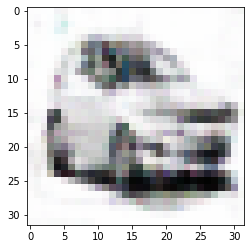

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise)[0])

In [ ]:
# Real Image
#t = Image.open(dataset.fpaths[999])
#t = (transform(t).permute(1, 2, 0)+1)/2.
#imshow(t)

In [ ]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [ ]:

# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1,
                 'D':D.state_dict(),
                 'G':G.state_dict(),
                 'd_optim': D_opt.state_dict(),
                 'g_optim' : G_opt.state_dict()},
                'dcgan.pth.tar')